In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
# api.dataset_download_files('robervalt/sunspots', path="data/", unzip=True)

In [2]:
time_step, sunspots = [], []
with open("data/Sunspots.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    headers = next(reader) 
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

series = np.array(sunspots)
time = np.array(time_step)
len(series)

3265

Text(0, 0.5, 'Monthly Mean Total Sunspot Number')

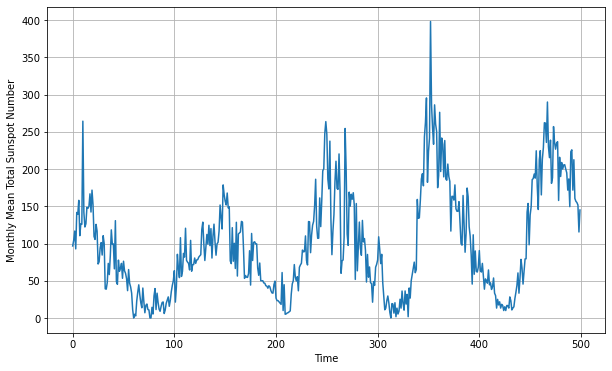

In [3]:
plt.figure(figsize=(10,6))
plt.plot(time[:500], series[:500])
plt.grid()
plt.xlabel("Time")
plt.ylabel(headers[2])

In [4]:
split_time = 3000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # transpose
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def plot_loss_vs_mae(history):
    mae = history.history['mae']
    loss= history.history['loss']
    epochs=range(len(loss))

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    p1,  = ax.plot(epochs, mae, 'r', label="MAE")
    p2,  = ax2.plot(epochs, loss, 'b', label="Loss")
    ax.set_title('MAE and Loss')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MAE")
    ax2.set_ylabel("Loss")
    ax.legend(handles=[p1, p2])


    epochs_zoom = epochs[300:]
    mae_zoom = mae[300:]
    loss_zoom = loss[300:]

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    p1,  = ax.plot(epochs_zoom, mae_zoom, 'r', label="MAE")
    p2,  = ax2.plot(epochs_zoom, loss_zoom, 'b', label="Loss")
    ax.set_title('MAE and Loss')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MAE")
    ax2.set_ylabel("Loss")
    ax.legend(handles=[p1, p2])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [35]:
window_size = 12*13
batch_size = 128 #256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [62]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=60, kernel_size=5,
#                         strides=1, padding="causal",
#                         activation="relu",
#                         input_shape=[None, 1]),
#     tf.keras.layers.LSTM(60, return_sequences=True),
#     tf.keras.layers.LSTM(60, return_sequences=True),
#     tf.keras.layers.Dense(30, activation="relu"),
#     tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * 400)
# ])



model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])
ADAMoptimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model.compile(loss=tf.keras.losses.Huber(), optimizer=ADAMoptimizer, metrics=["mae"])

In [63]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 60)          240       
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 60)          29040     
_________________________________________________________________
batch_normalization_19 (Batc (None, None, 60)          240       
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 60)          29040     
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 60)          240       
_________________________________________________________________
dense_24 (Dense)             (None, None, 30)         

In [64]:
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule], verbose=0)

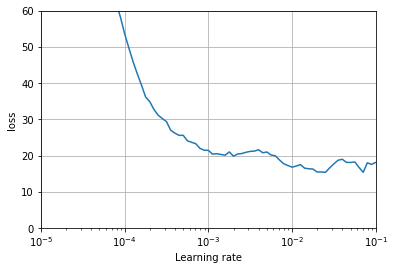

In [67]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 60])
plt.xlabel("Learning rate")
plt.ylabel("loss")
plt.grid()

In [68]:
# SGDoptimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(), optimizer=SGDoptimizer, metrics=["mae"])
ADAMoptimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss=tf.keras.losses.Huber(), optimizer=ADAMoptimizer, metrics=["mae"])

In [69]:
# history = model.fit(train_set, epochs=400, verbose=0)
history = model.fit(
    train_set, epochs=500, verbose=1, 
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', patience=15, cooldown=10, verbose=1, min_lr=1e-05),
        tf.keras.callbacks.EarlyStopping(monitor='mae', patience=50, verbose=1, restore_best_weights=True),
    ]
)

Epoch 1/500
23/23 [==============================] - 5s 236ms/step - loss: 13.2820 - mae: 13.884113.2772 - mae: 13.88
Epoch 2/500
23/23 [==============================] - 1s 55ms/step - loss: 11.6528 - mae: 12.2094
Epoch 3/500
23/23 [==============================] - 1s 57ms/step - loss: 11.6329 - mae: 12.1876
Epoch 4/500
23/23 [==============================] - 1s 53ms/step - loss: 11.5522 - mae: 12.1125
Epoch 5/500
23/23 [==============================] - 1s 53ms/step - loss: 10.6243 - mae: 11.1619
Epoch 6/500
23/23 [==============================] - 1s 54ms/step - loss: 9.8882 - mae: 10.1834
Epoch 7/500
23/23 [==============================] - 1s 54ms/step - loss: 9.6791 - mae: 10.1617
Epoch 8/500
23/23 [==============================] - 1s 52ms/step - loss: 9.4618 - mae: 9.8216
Epoch 9/500
23/23 [==============================] - 1s 52ms/step - loss: 10.9169 - mae: 11.4289: 0s - loss: 11.2626 - mae: 11.74
Epoch 10/500
23/23 [==============================] - 1s 53ms/step - loss: 10

In [81]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

16.785446

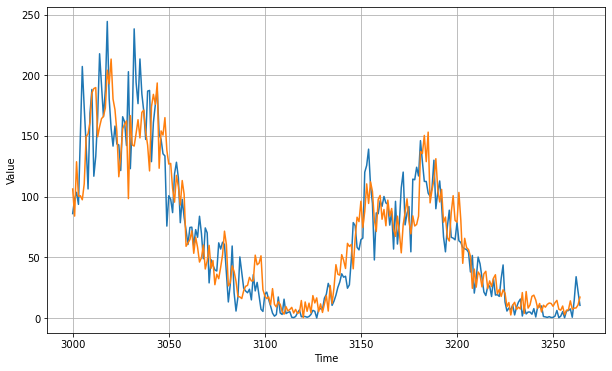

In [82]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

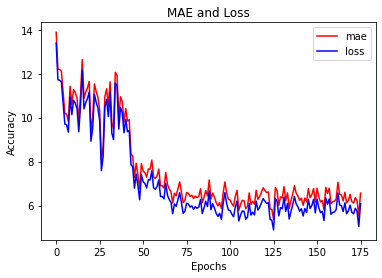

In [84]:
# plot_loss_vs_mae(history)

mae = history.history['mae']
loss= history.history['loss']
epochs=range(len(loss))

p1 = plt.plot(epochs, mae, 'r', label="MAE")
p2 = plt.plot(epochs, loss, 'b', label="Loss")
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["mae", "loss"])



In [73]:
def model_forecast_forward(model, forecast, window_size, max_future=12*100):
    forecast = np.array(forecast).copy()
    for time in range(max_future):
        window   = forecast[-window_size:][np.newaxis]
        pred     = model.predict(window)[-1][-1]
        forecast = np.append(forecast, pred)
        # print(time, pred, window, forecast.shape)
    return forecast

In [74]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

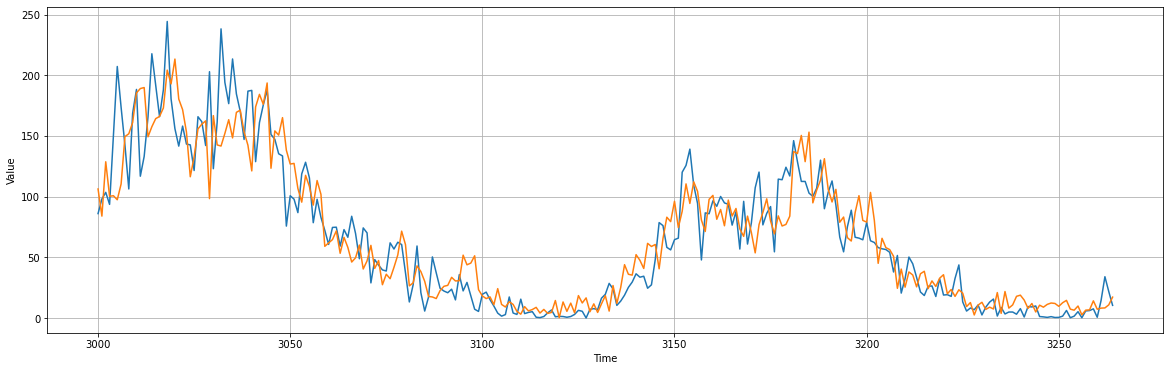

In [79]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)